In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict
from simulator import get_simulator
from simulate import simulate
from simulate import mpi_simulate

# Simulating The Chemical Network 

# $e^{i\pi} + 1 = 0$

In [2]:
system = {
    'duration': 9999.0, # how much time each simulation trajectory represents
    'resolution': 1.0,  # how often the state of the system is recorded for output
    'species': [
        ('i', 0),  # competing protein mRNA (CFP mRNA)
        ('a', 0),  # antitoxin mRNA (mazE)
        ('t', 0),  # toxin mRNA (mazF)
        ('I', 0),  # competing protein (CFP)
        ('A', 0),  # antitoxin (MazE)
        ('T', 0),  # toxin (MazF)
        ('TT', 0), # toxin dimer
        ('C', 0),  # toxin-antitoxin complex (MazE bound to MazF dimer)
        ('CC', 0), # toxin-antitoxin complex dimer
    ],
    'reactions': [
        ('lambda_i', 
             (), 
             ((1, 'i'), )
        ), # transcription of competing protein mRNA
        ('lambda_ta', 
             (), 
             ((1, 't'), (1, 'a')),
        ), # transcription of toxin and antitoxin mRNAs

        ('F_i', 
             ((1, 'i'), ), 
             ()
        ), # cleavage of competing protein mRNA by free toxin
        ('F_a', 
             ((1, 'a'), ), 
             ()
        ), # cleavage of antitoxin mRNA
        ('F_t', 
             ((1, 't'), ), 
             ()
        ), # cleavage of toxin mRNA

        ('alpha_i', 
             ((1, 'i'), ), 
             ((1, 'i'), (1, 'I'))
        ), # translation of competing protein
        ('alpha_a', 
             ((1, 'a'), ), 
             ((1, 'a'), (1, 'A'))
        ), # translation of antitoxin
        ('alpha_t', 
             ((1, 't'), ), 
             ((1, 't'), (1, 'T'))
        ), # translation of toxin

        ('k_C', 
             ((2, 'T'), ), 
             ((1, 'TT'), )
        ), # toxin dimer formation
        ('k_C', 
             ((1, 'TT'), (1, 'A')), 
             ((1, 'C'), )
        ), # complex formation
        ('k_C', 
             ((2, 'C'), ), 
             ((1, 'CC'), )
        ), # complex dimerization

        ('G_I', 
             ((1, 'I'), ), 
             ()
        ), # degradation of competing protein
        ('G_A', 
             ((1, 'A'), ), 
             ()
        ), # degradation of antitoxin
        ('G_T', 
             ((1, 'T'), ), 
             ()), # degradation of toxin
        ('G_T', 
             ((1, 'TT'), ), 
             ((1, 'T'), )
        ), # degradation of toxin bound in toxin dimer
        ('G_C', 
             ((1, 'C'), ), 
             ((1, 'TT'), )
        ), # degradation of antitoxin bound in complex
        ('G_C', 
             ((1, 'CC'), ), 
             ((1, 'TT'), (1, 'C'))
        ), # degradation of antitoxin bound in complex dimer

        ('Gamma', ((1, 'i'), ), ()),                     # dilution of competing protein mRNA
        ('Gamma', ((1, 'a'), ), ()),                     # dilution of antitoxin mRNA
        ('Gamma', ((1, 't'), ), ()),                     # dilution of toxin mRNA
        ('Gamma', ((1, 'I'), ), ()),                     # dilution of competing protein
        ('Gamma', ((1, 'A'), ), ()),                     # dilution of antitoxin
        ('Gamma', ((1, 'T'), ), ()),                     # dilution of toxin
        ('Gamma', ((1, 'TT'), ), ()),                    # dilution of toxin dimer
        ('Gamma', ((1, 'C'), ), ()),                     # dilution of complex
        ('Gamma', ((1, 'CC'), ), ()),                    # dilution of complex dimer
    ], 
    'variables': [
        ('lambda_i', 20.0), # transcription rate competing protein mRNA
        ('sigma_ta', 20.0), # basal transcription rate of toxin and antitoxin mRNAs
        ('alpha_i', 200.0), # translation rate of competing protein mRNA
        ('alpha_t', 200.0), # translation rate of toxin
        ('mu_i', 5.0),      # basal degradation rate of competing protein mRNA
        ('k_0', 0.05),      # basal repression factor for toxin antitoxin mRNA
        ('nu', 1.6),        # relative translation rate of antitoxin to toxin
        ('k_C', 1000.0),    # rate of complex formation
        ('mu_ta', 5.0),     # basal degradation rate of toxin and antitoxin mRNAs
        ('f_T', 20.0),      # mRNA cleavage factor by free toxin
        ('omega', 0.2),     # relative cleavage rate of antitoxin to toxin
        ('delta', 1.5),     # relative cleavage rate of competing protein to toxin
        ('mu', 100.0),      # degradation velocity of all proteolytic pathways
        ('epsilon', 0.01),  # affinity of non-degradation state
        ('kappa_I', 1.0),   # affinity factor of competing protein
        ('kappa_M', 1.0),   # affinity factor of entire toxin antitoxin module
        ('kappa_A', 1.0),   # affinity factor of antitoxin
        ('kappa_T_1', 0.00001),   # affinity factor of toxin
        #('kappa_T_2', 0.00001),   # affinity factor of toxin
        ('kappa_C', 0.1),   # affinity factor of complex
        ('gamma', 1.0),     # basal dilution rate (sets the time units of the system)
        ('beta_g', 0.25),   # growth rate factor for inhibition of growth by free toxin
        ('eta_p', 0.5),     # proteolytic coupling parameter
        ('phi', 1.0),
    ], 
    'functions': [
        ('lambda_ta', 'sigma_ta / (1 + k_0 * (A + C + CC))'), # rate of toxin and antitoxin mRNAs
        
        ('alpha_a', 'alpha_t * nu'), # nu > 1 so that translation of antitoxin is faster than toxin

        ('F_t', 'mu_ta + f_T * (T + TT)'), # cleavage of toxin mRNA which increases as toxin accumulates
        ('F_i', 'mu_i  + f_T * (T + TT) * delta'), # delta = 1.5 so that competing protein mRNA cleavage is faster
        ('F_a', 'mu_ta + f_T * (T + TT) * omega'), # omega = 0.2 so that antitoxin mRNA cleavage is slower than toxin



        ('M_1', '(kappa_A * A + kappa_C * (C + CC) + kappa_T_1 * (T + TT))'),
        ('M_2', '(kappa_A * A + kappa_C * (C + CC) + kappa_T_2 * (T + TT))'),
        #('kappa_G_I', 'kappa_I * I'),

        # coupling of module with competing protein is modulated symmetrically
        #('kappa_p_1', 'eta_p'),
        #('kappa_p_2', '1.0 - eta_p'),
        #('G1', 'mu / (epsilon + kappa_p_2 * kappa_I * I + kappa_p_1 * kappa_M * M)'),
        #('G2', 'mu / (epsilon + kappa_p_1 * kappa_I * I + kappa_p_2 * kappa_M * M)'),
        #('G_I', '(          kappa_I) * (kappa_p_2 * G1 + kappa_p_1 * G2)'),
        #('G_A', '(kappa_A * kappa_M) * (kappa_p_1 * G1 + kappa_p_2 * G2)'),
        #('G_C', '(kappa_C * kappa_M) * (kappa_p_1 * G1 + kappa_p_2 * G2)'),
        #('G_T', '(kappa_T * kappa_M) * (kappa_p_1 * G1 + kappa_p_2 * G2)'),

        # coupling is modulated asymmetrically
        #('kappa_p_1', 'eta_p'),
        #('kappa_p_2', '1.0 - eta_p'),
        #('G1', 'mu / (epsilon + kappa_p_2 * kappa_I * I + kappa_p_1 * kappa_M * M)'),
        #('G1', 'mu / (epsilon + kappa_p_1 * kappa_I * I + kappa_M * M)'),
        #('G2', 'mu / (epsilon + kappa_p_2 * kappa_I * I)'),
        #('G_I', '(          kappa_I) * (kappa_p_1 * G1 + kappa_p_2 * G2)'),
        #('G_A', '(kappa_A * kappa_M) * G1'),
        #('G_C', '(kappa_C * kappa_M) * G1'),
        #('G_T', '(kappa_T * kappa_M) * G1'),

        ('kappa_T_2', 'phi * kappa_T_1'),
        ('kappa_p_1', 'eta_p'),
        ('kappa_p_2', '1.0 - eta_p'),
        
        ('G1', 'mu / (epsilon + kappa_p_2 * kappa_I * I + kappa_M * M_1)'),
        ('G2', 'mu / (epsilon + kappa_p_1 * kappa_I * I + kappa_M * M_2)'),
        ('G_I', '(          kappa_I) * (kappa_p_2 * G1 + kappa_p_1 * G2)'),
        ('G_A', '(kappa_A * kappa_M) * (G1 + G2)'),
        ('G_C', '(kappa_C * kappa_M) * (G1 + G2)'),
        ('G_T', '(          kappa_M) * (kappa_T_1 * G1 + kappa_T_2 * G2)'),

        
        ('Gamma', 'gamma / (1.0 + beta_g * (T + TT))'),

        ('T_free', 'T + TT'), 
    ], 
    'targets': [ # set of system quantities which are recorded for output and analysis
        'time', 
        'i', 
        'I',
        'A',
        'C',
        'CC',
        'T', 
        'TT',
        'T_free',
    ],
}

Compiling ./gillespie_6.pyx because it changed.
[1/1] Cythonizing ./gillespie_6.pyx
running clean
removing 'build/temp.linux-x86_64-3.6' (and everything under it)
removing 'build'
running build_ext
building 'gillespie_6' extension
creating build/temp.linux-x86_64-3.6
gcc -pthread -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/srv/cluster/anaconda3/lib/python3.6/site-packages/numpy/core/include -I/srv/cluster/anaconda3/include/python3.6m -c ./gillespie_6.c -o build/temp.linux-x86_64-3.6/./gillespie_6.o
gcc -pthread -shared -L/srv/cluster/anaconda3/lib -Wl,-rpath=/srv/cluster/anaconda3/lib,--no-as-needed build/temp.linux-x86_64-3.6/./gillespie_6.o -L/srv/cluster/anaconda3/lib -lpython3.6m -o /srv/cluster/mini_gillespiem/.simulators/gillespie_6.cpython-36m-x86_64-linux-gnu.so


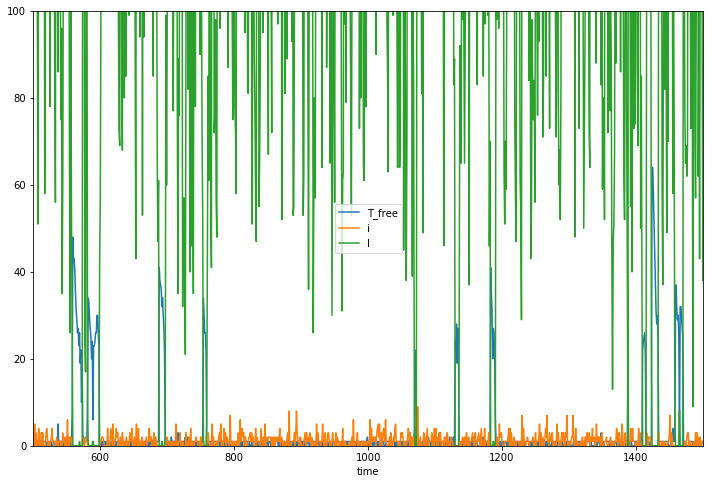

In [3]:
df = pd.DataFrame(OrderedDict((t, d) for t, d in zip(system['targets'], get_simulator(system)(0))))
df.plot(x='time', y=['T_free', 'i', 'I'], kind='line', figsize=(12, 8), xlim=(500, 1500), ylim=(0, 100))

# Measurements Of Toxicity Over Parameter Space 

In [ ]:
np.round(np.exp(np.linspace(np.log(0.01), np.log(100), 5)), 3)

In [ ]:
np.round(np.exp(np.linspace(np.log(0.0000001), np.log(1), 8)), 10)

In [ ]:
np.round(np.exp(np.linspace(np.log(1), np.log(100), 3)), 3)

In [4]:
from event_detection import event_detection
from pscan import pscan_view

processing = (
    (event_detection, ('time', 'T_free', 'I')), 
)

axes = (
    #('lambda_i', np.arange(10.0, 60.0 + 1e-10, 1.0)),
    #('lambda_i', np.arange(0.0, 20.0 + 1e-10, 1.0)),

    #('kappa_I', (0.1, )),
    ('kappa_I', np.round(np.exp(np.linspace(np.log(0.0000001), np.log(1), 40)), 10)),
    #('kappa_I', np.arange(0.0, 0.2 + 1e-10, 0.02)),
    #('kappa_I', np.arange(0.0, 1.0 + 1e-10, 0.05)),
    
    #('kappa_M', np.arange(0.0, 1.0 + 1e-10, 0.05)),
    
    #('kappa_T', (0.0, 0.0000001, 0.0)),
    
    #('eta_p', np.arange(0.0, 1.0 + 1e-10, 0.02)),
    ('eta_p', np.arange(0.0, 1.0 + 1e-10, 0.025)),
    
    #('phi', np.arange(0.0, 10.0 + 1e-10, 0.5)),
    #('phi', np.round(np.exp(np.linspace(np.log(0.01), np.log(100), 5)), 3)),
    ('phi', np.round(np.exp(np.linspace(np.log(1), np.log(100), 3)), 3)),
)

print('the axes:')
for a, v in axes:
    print(a, v)

#pspace, data = simulate(system, processing=processing, batchsize=10, axes=axes)
pspace, pscans = mpi_simulate(system, processing=processing, batchsize=10, axes=axes, hostfile='~/dev/hostfile')

Scanning Parameters:   0%|          | 0/4920 [00:00<?, ?it/s]

the axes:
kappa_I [  1.00000000e-07   1.51200000e-07   2.28500000e-07   3.45500000e-07
   5.22300000e-07   7.89700000e-07   1.19380000e-06   1.80470000e-06
   2.72830000e-06   4.12460000e-06   6.23550000e-06   9.42670000e-06
   1.42510000e-05   2.15443000e-05   3.25702000e-05   4.92388000e-05
   7.44380000e-05   1.12533600e-04   1.70125400e-04   2.57191400e-04
   3.88815500e-04   5.87801600e-04   8.88623800e-04   1.34339930e-03
   2.03091760e-03   3.07029060e-03   4.64158880e-03   7.01703830e-03
   1.06081836e-02   1.60371874e-02   2.42446202e-02   3.66524124e-02
   5.54102033e-02   8.37677640e-02   1.26638017e-01   1.91448198e-01
   2.89426613e-01   4.37547937e-01   6.61474064e-01   1.00000000e+00]
eta_p [ 0.     0.025  0.05   0.075  0.1    0.125  0.15   0.175  0.2    0.225
  0.25   0.275  0.3    0.325  0.35   0.375  0.4    0.425  0.45   0.475  0.5
  0.525  0.55   0.575  0.6    0.625  0.65   0.675  0.7    0.725  0.75
  0.775  0.8    0.825  0.85   0.875  0.9    0.925  0.95   0.975  1. 

started worker 1 / -1:   0%|          | 0/4920 [00:11<?, ?it/s]

setting up workers


started worker 18 / -1:   0%|          | 0/4920 [00:28<?, ?it/s]

Compiling ./gillespie_6.pyx because it changed.
[1/1] Cythonizing ./gillespie_6.pyx
running clean
removing 'build/temp.linux-x86_64-3.6' (and everything under it)
removing 'build'
running build_ext
building 'gillespie_6' extension
creating build/temp.linux-x86_64-3.6
gcc -pthread -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/srv/cluster/anaconda3/lib/python3.6/site-packages/numpy/core/include -I/srv/cluster/anaconda3/include/python3.6m -c ./gillespie_6.c -o build/temp.linux-x86_64-3.6/./gillespie_6.o


worker 5 / -1 setup up:   0%|          | 0/4920 [00:35<?, ?it/s]

gcc -pthread -shared -L/srv/cluster/anaconda3/lib -Wl,-rpath=/srv/cluster/anaconda3/lib,--no-as-needed build/temp.linux-x86_64-3.6/./gillespie_6.o -L/srv/cluster/anaconda3/lib -lpython3.6m -o /srv/cluster/mini_gillespiem/.simulators/gillespie_6.cpython-36m-x86_64-linux-gnu.so


worker 22 / -1 setup up:   0%|          | 0/4920 [00:36<?, ?it/s]

set up workers


worker 14 / -1 ran location: 100%|██████████| 4920/4920 [7:00:03<00:00,  2.36s/it]   

saving output data...
worker 7 halt
worker 4 halt
worker 6 halt
worker 1 halt
worker 3 halt
worker 2 halt
worker 5 halt
worker 9 halt
worker 8 halt
worker 10 halt
worker 11 halt
worker 16 halt
worker 14 halt
worker 12 halt
worker 18 halt
worker 21 halt
worker 23 halt
worker 15 halt
worker 17 halt
worker 19 halt
worker 20 halt
worker 13 halt
worker 22 halt
saved output data
end dispatch 0 ./.simulators/run.json


loading output data...
loaded output data


# Viewing Measurements 

In [ ]:
pscans[0]

In [5]:
pscan = pscans[0]
subspace = {
    #'kappa_T': 0.0000001, 
    #'kappa_T': 0, 
    'kappa_I': 0.1, 
    #'kappa_M': 0.5, 
    #'lambda_i': 20, 
    'phi': 10.0, 
}
targets = ('time', 'T_free', 'I')

selection = pscan_view(pscan, subspace, targets)
selection.shape, selection.columns

trajectory = 0
target = 'T_free'

time_selection = selection.loc[selection['Target'] == 'time'].reset_index()
target_selection = selection.loc[selection['Target'] == target].reset_index()

n_fig = target_selection.shape[0]
f, axes = plt.subplots(n_fig, 1, figsize=(12, 2 * n_fig))
f.subplots_adjust(wspace=0.8, hspace=0.8)
for (t, time), (l, location), ax in zip(time_selection.iterrows(), target_selection.iterrows(), axes):
    subspace = location[pspace.columns]
    subspace = ', '.join(('%s: %s' % (i, j)) for i, j in zip(subspace.index, subspace.values))
    ax.set_title('location: %s' % subspace)
    counts = location['Batch'][trajectory, :]
    time = time['Batch'][trajectory, :]
    ax.plot(time, counts, linewidth=3)
    events = location['Events']
    if events and sum([len(e) for e in events]):
        parameters = location['Parameters']
        high, low = parameters['high'], parameters['low']
        medium = (high + low) / 2.0
        ax.plot([time[0] - 1, time[-1] + 1], [low, low], color='k', ls='--')
        ax.plot([time[0] - 1, time[-1] + 1], [medium, medium], color='k', ls='--')
        ax.plot([time[0] - 1, time[-1] + 1], [high, high], color='k', ls='--')
        for i, j in events[trajectory]:
            ax.plot([time[i], time[j]], [medium, medium], color='r', lw=5, marker='s')
    ax.set_xlim((0.2 * time.shape[0], min(0.2 * time.shape[0] + 1000, time[-1])))

IndexError: index out of range

In [ ]:
target_selection.columns

TypeError: Empty 'DataFrame': no numeric data to plot

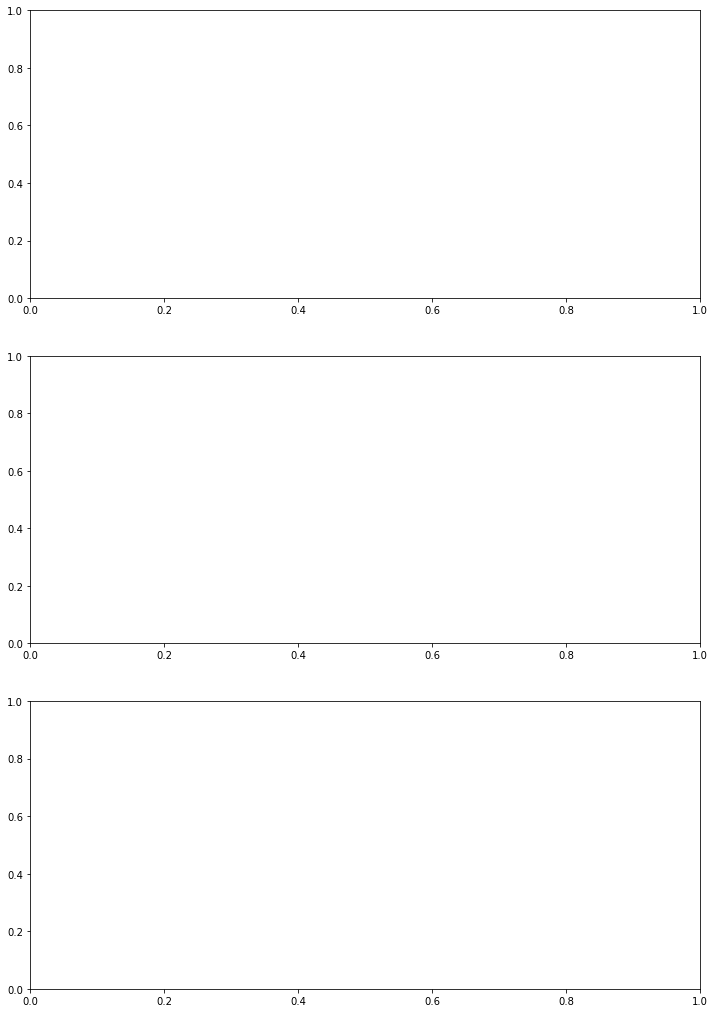

In [6]:
pscan = pscans[0]
subspace = {
    #'kappa_T': 0.0000001, 
    #'kappa_T': 0, 
    'kappa_I': 0.1, 
    #'kappa_M': 1.0, 
    #'lambda_i': 5, 
    'phi': 100.0, 
}
targets = ('time', 'T_free', 'I')

selection = pscan_view(pscan, subspace, targets)
selection.shape, selection.columns

trajectory = 0
target = 'T_free'

time_selection = selection.loc[selection['Target'] == 'time'].reset_index()
target_selection = selection.loc[selection['Target'] == target].reset_index()

x = 'eta_p'
ys = [['Toxic Probability'], ['Mean Event Duration'], ['Event Count']]

#print(target_selection[x])

n = len(ys)
f, axes = plt.subplots(n, 1, figsize=(12, n * 6))
for ax, targets in zip(axes, ys):
    target_selection.plot(x=x, y=targets, ax=ax)
    ax.set_title('%s Versus %s' % (', '.join(targets), x))
    ax.set_xlabel(x)
    ax.set_ylabel(', '.join(targets))

(1640,) (1640,) (1640,)
(40,) (41,) (1640,)
(1640, 1640) (1640, 1640)
(40, 41)


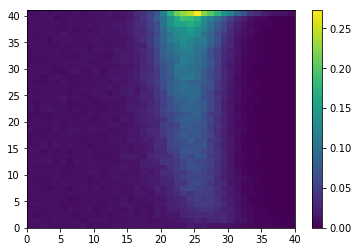

In [7]:
pscan = pscans[0]
subspace = {
    #'kappa_T': 0.0000001, 
    #'kappa_T': 0, 
    #'kappa_I': 0.1, 
    'phi': 100.0, 
    #'sigma_i': 20, 
}
targets = ('time', 'T_free', 'I')
target = 'T_free'

selection = pscan_view(pscan, subspace, targets)
selection = selection.loc[selection['Target'] == target].reset_index()
selection.shape, selection.columns

x = selection['kappa_I'].values
#x = selection['phi'].values
y = selection['eta_p'].values
z = selection['Toxic Probability'].values
print(x.shape, y.shape, z.shape)
print(np.unique(x).shape, np.unique(y).shape, z.shape)

X, Y = np.meshgrid(x, y)
print(X.shape, Y.shape)
print(z.reshape(np.unique(x).shape[0], np.unique(y).shape[0]).shape)
plt.pcolor(z.reshape(np.unique(x).shape[0], np.unique(y).shape[0]).transpose())
plt.colorbar()

In [ ]:
selection[['lambda_i', 'eta_p', 'Toxic Probability']].head()